# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import serial
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.io import wavfile
from difflib import SequenceMatcher
%matplotlib inline

# Question Bank

In [2]:
with open ("Book3.csv", "r") as f:
    data = f.read()
#data.split("\n")
qbank = []

for line in data.split("\n"):
    #rint(line)
    if ',' not in line:
        continue
    q,a = line.strip().split(',')
    if a[0].lower() == "t":
        qbank.append((q,True))
    else:
        qbank.append((q,False))

for line in qbank:
    print(line)

('The universe is 13.8 billion years old.', True)
('The constellation Virgo is the hottest place in the universe.', True)
('Jupiter is the largest planet in our solar system.', True)
('Apollo 17 was the last NASA manned mission space filght to the moon.', True)
('There is only one moon in our solar system.', False)
('The shortest space flight was 25 minutes.', False)
('Light cannot escape from a black hole.', True)
('There are 9 planets in the solar system.', False)
('Red supergiant stars are the largest type of stars in the universe.', True)
('Elliptical galaxies are not the most common galaxies in the universe.', False)
('An ant can fit 100 times its own weight.', False)
('8128 is a perfect number.', True)
('There are 24 time zones in the world.', True)
('AB postitive is the rarest blood type in humans.', False)
('An octopus has only one heart.', False)
('Hydrogen is the first element on the periodic table.', True)
('There are seven colors in a rainbow.', True)
('Dolphins cannot smel

# Clean Function

In [3]:
def clean_function(R):
    Fs = 10000;
    T = np.linspace(1, len(R), len(R))/Fs
    nffte = len(T)
    X = np.fft.fft(R,nffte)
    X = np.fft.fftshift(X)

    f = np.linspace(-nffte/2,nffte/2-1,len(X))*Fs/nffte


    X[abs(f)>15]=0

    R1 = np.fft.ifftshift(X)
    R = np.fft.ifft(R1)
    return R

def normalize(R):
    #transfer to normalize graph
    max_r = max(R)
    min_r = min(R)
    if abs(min_r) > max_r:
        max_r = abs(min_r)
    for index in range(len(R)):
        R[index] /= max_r
    plt.figure()
    plt.plot(R)
    return R

# Event Function

In [4]:
#detect events
def event_function(R,Fs):    
    window_size = Fs*1
    start_point = 0
    event_list = []
    var_list = []
    var_start = 0
    
    while True:
        if var_start+len(R)/Fs/10 >= len(R):
            break
        win = R[int(var_start):int(var_start+Fs/2)]
        var_list.append(np.var(win))
        var_start+=len(R)/Fs/3

    while True:
        if start_point+window_size<=len(R):
            window = R[int(start_point):int((start_point+window_size/2))]
            window_var = np.var(window)
            if window_var >= 0.072:
                if start_point-Fs/5 > 0:
                    event_list.append(start_point-Fs/5)
                else:
                    event_list.append(start_point)
                start_point+=Fs*1.25
            else:
                start_point += len(R)/Fs/3
            if start_point+len(R)/Fs/3 >=len(R):
                break
        else:
            break
    print(len(event_list))
    print(event_list)
#     plt.figure()
#     plt.plot(var_list)
    return event_list
#detect direction
def direction_function(event_list,Fs):    
    direction_list = []
    for event in event_list:
        event_period = R[int(event):int(event+Fs/2)]
        max_pos=np.argwhere(R==max(event_period))
        min_pos=np.argwhere(R==min(event_period))
        if max_pos <min_pos:
            direction_list.append("L")
        else:
            direction_list.append("R")
#     print(direction_list)
#     print(np.mean(var_list))
    return direction_list
#machine learning
def point_interval(event_list,R,Fs):
    result_list = []
    for ele in event_list:
        result_list.append(R[int(ele):int(ele+Fs)])
    return result_list   
def randomforest(event_list):    
    features = np.array(event_list).astype(float)
    labels = [1,1,0,0,0,0,1,1,1,1,0,0,0,0]
    #labels = [1,1,1,1,0,0,0,0]
    labels = np.array(labels)
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    rf.fit(features,labels)
    return rf

def hard_blink_delete(R,Fs):
    var_list = []
    var_start = 0
    
    while True:
        if var_start+len(R)/Fs/10 >= len(R):
            break
        win = R[int(var_start):int(var_start+Fs/2)]
        temp_var = np.var(win)
        if temp_var > 100000:
            temp_a = R[:int(var_start)]
            temp_b = R[int(var_start)+Fs*2:]
            R= np.concatenate((temp_a, temp_b))
        else:
            var_list.append(np.var(win))
        var_start+=len(R)/Fs/3
#     fig = plt.figure()
#     plt.plot(R)
    return R
    
def hard_blink_detect(R,Fs):
    var_list = []
    var_start = 0
    
    while True:
        if var_start+len(R)/Fs/10 >= len(R):
            break
        win = R[int(var_start):int(var_start+Fs/2)]
        temp_var = np.var(win)
        if temp_var > 300000:
            return True
    return False


# Soft Blinks

In [5]:
ylab1 = [1,0,1,0,0,1,0,0,0,1,1,1,0,0]
ylab2 = [1,1,0,0,1,0,1,0,1,0,1,0]
ylab3 = [1,0,0,0,1,1,0,1,0,0,0,1,1]
ylab4 = [1,0,0,0,0,1,1,0,1,1,1,1,0,0,0,1]
ylab5 = [0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,1,1,1]
ylab6 = [1,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0]
ylab7 = [1,1,0,0,0,1,1,0,0,0,1,1,0,0,1]
ylab8 = [1,0,0,1,0,1,0,1,0]
ylab9 = [1,0,0,0,1,0,1,0,1,0,0,1,1,0,1]

# Machine Learning Alternate Detection

14
[14863.590000000422, 37546.120833331304, 60040.231666660686, 76520.60416665912, 92286.5508333245, 108476.4424999897, 121667.31583332276, 134167.31583332276, 148928.35583332187, 161428.35583332187, 173928.35583332187, 186428.35583332187, 198928.35583332187, 211428.35583332187]


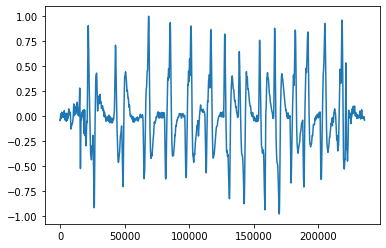

In [6]:
from scipy.io import wavfile
[Fs,R]=wavfile.read('regular calibration 2 end.wav')
#[Fs,R]=wavfile.read('new calibrate.wav')

R = clean_function(R)#R is calibration 
maxR = max(abs(R))
R = normalize(R)
event_list = event_function(R,Fs)
event_interval = point_interval(event_list,R,Fs)
rf = randomforest(event_interval)

In [39]:
from scipy.io import wavfile

WAVES = np.zeros((9,796225)) #796225 repesents the longest length of a single wave file
FS = np.zeros(9)

[Fs0,Y0]=wavfile.read('LR softblink 1.wav')
WAVES[0,0:len(Y0)] = Y0
FS[0] = Fs0

[Fs1,Y1]=wavfile.read('LR softblink 2.wav')
WAVES[1, 0:len(Y1)] = Y1
FS[1] = Fs1

[Fs2,Y2]=wavfile.read('LR softblink 3.wav')
WAVES[2, 0:len(Y2)] = Y2
FS[2] = Fs2

[Fs3,Y3]=wavfile.read('LR softblink 4.wav')
WAVES[3, 0:len(Y3)] = Y3
FS[3] = Fs3

[Fs4,Y4]=wavfile.read('LR softblink 5.wav')
WAVES[4, 0:len(Y4)] = Y4
FS[4] = Fs4

[Fs5,Y5]=wavfile.read('LR softblink 6.wav')
WAVES[5, 0:len(Y5)] = Y5
FS[5] = Fs5

[Fs6,Y6]=wavfile.read('LR softblink 7.wav')
WAVES[6, 0:len(Y6)] = Y6
FS[6] = Fs6

[Fs7,Y7]=wavfile.read('LR softblink 8.wav')
WAVES[7, 0:len(Y7)] = Y7
FS[7] = Fs7

[Fs8,Y8]=wavfile.read('LR softblink 9.wav')
WAVES[8, 0:len(Y8)] = Y8
FS[8] = Fs8


WAVES = WAVES/maxR

In [12]:
WAVES

array([[-0.05261166, -0.05067741, -0.0483563 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.05570646, -0.05531961, -0.05454591, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.13075544,  0.13152915,  0.13152915, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.05299851,  0.0475826 ,  0.04177985, ...,  0.        ,
         0.        ,  0.        ],
       [-0.23713931, -0.24062097, -0.24410262, ...,  0.        ,
         0.        ,  0.        ],
       [-0.1381056 , -0.14622946, -0.15512702, ...,  0.        ,
         0.        ,  0.        ]])

In [8]:
#METHOD 2 MACHINE LEARNING
p = 0
read = qbank #change this line in order to read different qbank (e.g.'read = qbank3' to read qbank3)


# #random.shuffle(qbank)
correct = 0
s = 0

# print("Left = True, Right = False\n")
q,a = read[p]
# # print(p+1,q)

# #Run time: int(round(50/TWindow))
#c = np.asscalar(np.round(len(WAVES[k,:])/FS[k])-1)

            
r = [];
rime = [];



# average_signal = sum(Y)/(len(Y))



# print(len(events))
# print(events)
# for line in events:
#     print(len(line))


# user_answer = events

 
correct = 0
Predictions = np.ones((9,30))*100
#print(len(user_answer))
for k in range(0,len(Predictions[:,1])):
    event_point = event_function(WAVES[k,:],10000)
    events = point_interval(event_point,WAVES[k,:],10000)
    user_answer = np.array(events).astype(float)
    answer_list = []
    for num in range(0,len(user_answer)):
        #print(user_result)
        p_1 = p % 10

        q,a = read[p_1]
        #print(p+1,q)



        user_result = rf.predict([user_answer[num]])

        if user_result > 0.4:
            answer_list.append(1)

            if a == True:

                r.append('correct')
                correct+=1
            else:
                r.append('not correct')
        else:
            answer_list.append(0)

            if a == False:
                r.append('correct')
                correct+=1
            else:
                r.append('not correct')
        #print(r[len(r)-1],answer_list[len(answer_list)-1],a)
        #print()
        p += 1


    print(r)
    print(answer_list)
    print("Time is up!", "Your Score:", correct, "Out of", p-s, ", Skipped:", s)
    print('First boolean is user input, second is true answer')

    Predictions[k, 0:len(answer_list)] = answer_list






14
[28283.090833332717, 70960.01833333184, 114300.46666666427, 153792.4941666635, 186649.31333332957, 222929.89999999554, 249151.51083332847, 279964.68583332794, 322270.0416666604, 380048.70333332574, 418187.148333325, 444886.4941666579, 482042.92833332386, 524189.0391666605]
['correct', 'not correct', 'correct', 'not correct', 'correct', 'not correct', 'not correct', 'correct', 'not correct', 'correct', 'correct', 'correct', 'not correct', 'not correct']
[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]
Time is up! Your Score: 7 Out of 14 , Skipped: 0
First boolean is user input, second is true answer
12
[16074.30749999974, 37996.3033333328, 90705.66583333163, 115202.12249999795, 141344.1108333309, 164619.6891666639, 184736.90833333036, 205729.97499999678, 226218.76583332988, 261092.68833332922, 301248.23666666175, 337236.87416666106]
['correct', 'not correct', 'correct', 'not correct', 'correct', 'not correct', 'not correct', 'correct', 'not correct', 'correct', 'correct', 'correct', 'not c

10
[0, 155067.91916666244, 193524.85416666168, 235113.60749999416, 278241.72916665993, 330234.4891666588, 375538.9591666578, 425302.28916665673, 467209.5324999892, 513442.9316666549]
['correct', 'not correct', 'correct', 'not correct', 'correct', 'not correct', 'not correct', 'correct', 'not correct', 'correct', 'correct', 'correct', 'not correct', 'not correct', 'correct', 'not correct', 'not correct', 'correct', 'correct', 'correct', 'correct', 'not correct', 'correct', 'not correct', 'not correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'not correct', 'correct', 'not correct', 'correct', 'correct', 'correct', 'not correct', 'not correct', 'correct', 'not correct', 'not correct', 'not correct', 'not correct', 'not correct', 'not correct', 'not correct', 'not correct', 'not correct', 'correct', 'not correct', 'correct', 'not correct', 'not correct', 'not correct', 'not correct', 'correct', 'not correct', 'not correct', 'not correct', 'not correct', 'correct', 'correct'

In [54]:
Predictions

array([[  0.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1., 100., 100.],
       [  0.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1., 100., 100.],
       [  0.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1., 100., 100.],
       [  0.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1., 100., 100.],
       [  0.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   0., 

In [9]:
a = []
b = []
c = []
d = []
e = []
f = []
g = []
h = []
j = []

accs = []


for i in Predictions[0]:
    if i < 100:
        a.append(i)
s = SequenceMatcher(None, a, ylab1)
acc = s.ratio()
accs.append(acc)

for i in Predictions[1]:
    if i < 100:
        b.append(i)
s = SequenceMatcher(None, b, ylab2)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[2]:
    if i < 100:
        c.append(i)
s = SequenceMatcher(None, c, ylab3)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[3]:
    if i < 100:
        d.append(i)
s = SequenceMatcher(None, d, ylab4)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[4]:
    if i < 100:
        e.append(i)
s = SequenceMatcher(None, e, ylab5)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[5]:
    if i < 100:
        f.append(i)
s = SequenceMatcher(None, f, ylab6)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[6]:
    if i < 100:
        g.append(i)
s = SequenceMatcher(None, g, ylab7)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[7]:
    if i < 100:
        h.append(i)
s = SequenceMatcher(None, h, ylab8)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[8]:
    if i < 100:
        j.append(i)

s = SequenceMatcher(None, h, ylab9)
acc = s.ratio()
accs.append(acc)

In [10]:
print(accs)

[0.9285714285714286, 0.9166666666666666, 0.8461538461538461, 1.0, 0.8947368421052632, 0.8235294117647058, 0.6875, 0.42105263157894735, 0.48]


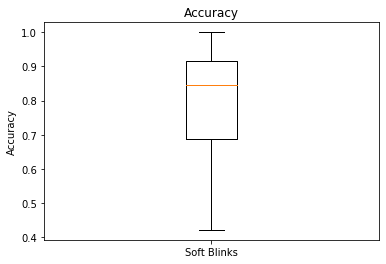

In [11]:
labels = ('Soft Blinks', 'random set 2')


fig = plt.boxplot(x = accs)
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xticks([1],labels)
plt.savefig('softblinks.png')
plt.show()



# A not too stellar result!


# Max Threshold Method

In [35]:
from scipy.io import wavfile
[Fs,R]=wavfile.read('new calibrate.wav')
#[Fs,R]=wavfile.read('regular calibration 2 end.wav')
Rsequence = [1,1,1,1,0,0,0,0];
Rsequence1 = [0,0,0,0,1,1,1,1];
#Rsequence = [1,1,0,0,0,0,1,1,1,1,0,0,0,0];

threshold = np.linspace(0.2,0.5,100)


R = clean_function(R)#R is calibration 


maxR = max(abs(R))
T = np.linspace(1, len(R), len(R))/Fs;
tsave = [];

for d in range(len(threshold)):

    TWindow = 0.05;    # observation interval
    threshold_level = threshold[d];

    TMax = max(T);  # maximum time recorded
    dT = T[1]-T[0]; # dT
    NWindow = TWindow/dT;   # number of points in Window
    delay_time = TWindow;   # wait the "recording interval" time
    Ra = R/maxR;

    r = [];
    time = [];
    RT = [];
    reset = 0;
    

    a = round(TMax/TWindow)

    for k in range(int(a)):



        window_index_beginning = 1+NWindow*(k);
        window_index_end = NWindow+NWindow*(k);
        window_index_range = np.linspace(window_index_beginning,window_index_end,window_index_end-window_index_beginning+1)


        blinkstest = max(abs(Ra[int(window_index_beginning):int(window_index_end)]));


        average_signal = sum(Ra[int(window_index_beginning):int(window_index_end)])/len(window_index_range);


        if reset % 30 == 0:
            reset = 0;


        if reset == 0:
            if blinkstest > 1.3:
                r = np.append(r,5);
                time = np.append(time,[TWindow*(k+1)]);
                reset = 1;
            elif average_signal>threshold_level:
                r = np.append(r,1);
                time = np.append(time,[TWindow*(k+1)]);
                reset = 1;
            elif average_signal<-threshold_level:
                r = np.append(r,0);
                time = np.append(time,[TWindow*(k+1)]);
                reset = 1;

        else:
            reset = reset + 1; 



    RT = np.stack((r, time))

    RT = RT.transpose()
    
    acca = SequenceMatcher(None, r, Rsequence);
    acca = acca.ratio()
    
    acca1 = SequenceMatcher(None,r,Rsequence1)
    acca1 = acca1.ratio()
    
    #print(RT)
    
    if acca == 1:
        tsave = np.append(tsave,threshold_level)
        sign = 1;
    elif acca1 == 1:
        tsave = np.append(tsave,threshold_level)
        sign = -1;
   

     
fourfive = round(0.8*len(tsave))
trem = tsave
threshold_level = tsave[int(fourfive)]


In [36]:
threshold_level

0.34545454545454546

In [40]:
Predictions = np.ones((9,21))*100

for k in range(0,len(FS)):
    #print(k)
    T = np.linspace(1, len(WAVES[k,:]), len(WAVES[k,:]))/FS[k]
    TMax = max(T);  # maximum time recorded
    
    TWindow = 0.05;    # observation interval
    dT = T[1]-T[0]; # dT
    NWindow = int(round(TWindow/dT));   # number of points in Window

    import time
    r = [];
    rime = [];
    RTtrue = [];
    reset = 0;
    reset_2 = 0;
    reset_3 = 0;

    PREDS = []


    import random


    p = 0
    random.shuffle(qbank)
    correct = 0
    s = 0

    print("Left = True, Right = False\n")
    q,a = qbank[p]
    print(p+1,q)

    #Run time: int(round(50/TWindow))
    c = np.asscalar(np.round(len(WAVES[k,:])/FS[k])-1)



    for i in range(0,int(c/TWindow)):
        #time.sleep(0.05)
        if i>=20: 

            if reset_2 != 0:
                if reset_2 % 30 == 0:
                    #print new question
                    q,a = qbank[p]
                    #print ('\n')
                    print(p+1,q)
                    reset_2 = 0;
                elif reset_2 == 20:
                    print('6 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 40:
                    print('5 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 60:
                    print('4 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 80:
                    print('3 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 100:
                    print('2 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 120:
                    print('1 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;

                else:
                    reset_2 = reset_2 + 1;

            elif reset_2 == 0:
                if reset != 0:
                    if reset % 30 == 0:
                        #print new question
                        q,a = qbank[p]
                        #print('\n')
                        print(p+1,q)
                        reset = 0;
                    elif reset == 20:
                        print('1 second\r',end='',flush=True)
                        reset = reset + 1;
                    else:
                        reset = reset + 1;


            if reset ==0:
                if reset_2 == 0:

                    r = [];
                    rime = [];


                    window_index_beginning = int(1+NWindow*(i)); # test if needs 1 or not
                    window_index_end = int(NWindow+NWindow*(i));


                    blinkstest = max(abs(sign*WAVES[k,:][window_index_beginning:window_index_end]));


                    average_signal = sum(sign*WAVES[k,:][window_index_beginning:window_index_end])/(window_index_end-window_index_beginning+1)





                    if reset_3 == 0:

                        if blinkstest > 1.3:
                            print('You skipped')
                            print(q,a,'\n')
                            #r = np.append(r,'Blink');
                            r = np.append(r,5)

                            PREDS = np.append(PREDS, 5)

                            rime = np.append(rime,[TWindow*(i+1)]);
                            #reset = 1
                            reset_2 = 1;
                            #reset_3 = 1;
                            p += 1
                            s += 1
                            #q,a = qbank[p]

                    if reset_2 == 0:
                        if average_signal>threshold_level:

                            #r = np.append(r,'Left');
                            r = np.append(r,1)

                            PREDS = np.append(PREDS, 1)

                            rime = np.append(rime,[TWindow*(i+1)]);
                            reset = 1;
                            usera= True
                            #usera = bool(usera)
                            # --- set user = none, while it's none, have the spiker box scan for signals; set a while loop to 
                            if usera == bool(a):
                                print("You said True, that is correct")
                                correct+= 1
                                #print(q,a)

                            else:
                                print("You said True, that is Incorrect")
                                #print(q,a)

                            print(q,a,'\n')
                            p += 1
                            #q,a = qbank[p]    
                            #print(p+1,q)
                            reset_3 = 0

                        elif average_signal<-threshold_level:

                            #r = np.append(r,'Right');
                            r = np.append(r,0)

                            PREDS = np.append(PREDS, 0)

                            rime = np.append(rime,[TWindow*(i+1)]);
                            reset = 1;
                            usera= False
                            #usera = bool(usera)
                            # --- set user = none, while it's none, have the spiker box scan for signals; set a while loop to 
                            if usera == bool(a):
                                print("You said False, that is correct")
                                #print(q,a)
                                correct+= 1  

                            else:
                                print("You said False, that is incorrect")
                                #print(q,a)
                                #d.pop(a[0])
                            print(q,a,'\n')
                            p += 1
                            #q,a = qbank[p]
                            #print(p+1,q)
                            reset_3 = 0
                        #else:
                            #reset = reset + 1


                    RT = np.stack((r, rime))

                    RT = RT.transpose()  


                    RTtrue = np.append(RTtrue,RT)
                    
    Predictions[k,0:len(PREDS)] = PREDS
                    

Left = True, Right = False

1 Leonardo Da Vinci painted the late 15th century mural known as Last Supper.
You said True, that is correct
Leonardo Da Vinci painted the late 15th century mural known as Last Supper. True 

2 SRGB has a wider range of colors than AdobeRGB.
You said False, that is correct
SRGB has a wider range of colors than AdobeRGB. False 

3 An octopus has only one heart.
You said True, that is Incorrect
An octopus has only one heart. False 

4 Jupiter is the largest planet in our solar system.
You said False, that is incorrect
Jupiter is the largest planet in our solar system. True 

5 Apollo 17 was the last NASA manned mission space filght to the moon.
You said False, that is incorrect
Apollo 17 was the last NASA manned mission space filght to the moon. True 

6 Celsius and Fahrenheit are equal at -40 degrees.
You said True, that is correct
Celsius and Fahrenheit are equal at -40 degrees. True 

7 444 is the three digit wen error code for censored content.
You said Fa

You said False, that is incorrect
Celsius and Fahrenheit are equal at -40 degrees. True 

5 Hydrogen is the first element on the periodic table.
You said True, that is correct
Hydrogen is the first element on the periodic table. True 

6 Elliptical galaxies are not the most common galaxies in the universe.
You said True, that is Incorrect
Elliptical galaxies are not the most common galaxies in the universe. False 

7 ROM stands for read only memory in computer memory.
You said True, that is correct
ROM stands for read only memory in computer memory. True 

8 Leonardo Da Vinci painted the late 15th century mural known as Last Supper.
You said True, that is correct
Leonardo Da Vinci painted the late 15th century mural known as Last Supper. True 

9 There are seven colors in a rainbow.
You said True, that is correct
There are seven colors in a rainbow. True 

10 The Titanic sank in 1913.
You said False, that is correct
The Titanic sank in 1913. False 

11 The name for the Greek goddess of

8 Queen Elizabeth II was born in 1926.
You said False, that is incorrect
Queen Elizabeth II was born in 1926. True 

9 World War II ended in 1945.
You said True, that is correct
World War II ended in 1945. True 

10 AB postitive is the rarest blood type in humans.
You said False, that is correct
AB postitive is the rarest blood type in humans. False 

11second 444 is the three digit wen error code for censored content.
You said False, that is correct
444 is the three digit wen error code for censored content. False 

12 Light cannot escape from a black hole.
Left = True, Right = False

1 An octopus has only one heart.
You said True, that is Incorrect
An octopus has only one heart. False 

2 ROM stands for read only memory in computer memory.
You said False, that is incorrect
ROM stands for read only memory in computer memory. True 

3 Zimbabwe was known as Rhodesia from 1964 to 1980.
You said False, that is incorrect
Zimbabwe was known as Rhodesia from 1964 to 1980. True 

4 Christophe

In [41]:
ylab1 = [1,0,1,0,0,1,0,0,0,1,1,1,0,0]
ylab2 = [1,1,0,0,1,0,1,0,1,0,1,0]
ylab3 = [1,0,0,0,1,1,0,1,0,0,0,1,1]
ylab4 = [1,0,0,0,0,1,1,0,1,1,1,1,0,0,0,1]
ylab5 = [0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,1,1,1]
ylab6 = [1,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0]
ylab7 = [1,1,0,0,0,1,1,0,0,0,1,1,0,0,1]
ylab8 = [1,0,0,1,0,1,0,1,0]
ylab9 = [1,0,0,0,1,0,1,0,1,0,0,1,1,0,1]

In [42]:
a = []
b = []
c = []
d = []
e = []
f = []
g = []
h = []
j = []

accs = []


for i in Predictions[0]:
    if i < 100:
        a.append(i)
s = SequenceMatcher(None, a, ylab1)
acc = s.ratio()
accs.append(acc)

for i in Predictions[1]:
    if i < 100:
        b.append(i)
s = SequenceMatcher(None, b, ylab2)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[2]:
    if i < 100:
        c.append(i)
s = SequenceMatcher(None, c, ylab3)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[3]:
    if i < 100:
        d.append(i)
s = SequenceMatcher(None, d, ylab4)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[4]:
    if i < 100:
        e.append(i)
s = SequenceMatcher(None, e, ylab5)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[5]:
    if i < 100:
        f.append(i)
s = SequenceMatcher(None, f, ylab6)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[6]:
    if i < 100:
        g.append(i)
s = SequenceMatcher(None, g, ylab7)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[7]:
    if i < 100:
        h.append(i)
s = SequenceMatcher(None, h, ylab8)
acc = s.ratio()
accs.append(acc)
        
for i in Predictions[8]:
    if i < 100:
        j.append(i)

s = SequenceMatcher(None, h, ylab9)
acc = s.ratio()
accs.append(acc)

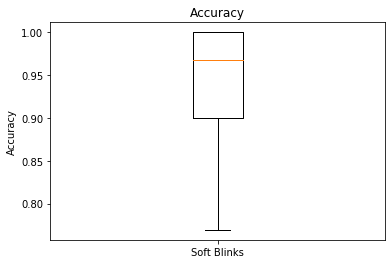

In [43]:
labels = ('Soft Blinks', 'random set 2')


fig = plt.boxplot(x = accs)
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xticks([1],labels)
plt.savefig('softblinks.png')
plt.show()



# Hard Blinks

In [44]:
from scipy.io import wavfile

WAVES = np.zeros((9,842558)) #796225 repesents the longest length of a single wave file
FS = np.zeros(9)

[Fs0,Y0]=wavfile.read('LR hardblink 1.wav')
WAVES[0,0:len(Y0)] = Y0
FS[0] = Fs0

[Fs1,Y1]=wavfile.read('LR hardblink 2.wav')
WAVES[1, 0:len(Y1)] = Y1
FS[1] = Fs1

[Fs2,Y2]=wavfile.read('LR hardblink 3.wav')
WAVES[2, 0:len(Y2)] = Y2
FS[2] = Fs2

[Fs3,Y3]=wavfile.read('LR hardblink 4.wav')
WAVES[3, 0:len(Y3)] = Y3
FS[3] = Fs3

[Fs4,Y4]=wavfile.read('LR hardblink 5.wav')
WAVES[4, 0:len(Y4)] = Y4
FS[4] = Fs4

[Fs5,Y5]=wavfile.read('LR hardblink 6.wav')
WAVES[5, 0:len(Y5)] = Y5
FS[5] = Fs5

[Fs6,Y6]=wavfile.read('LR hardblink 7.wav')
WAVES[6, 0:len(Y6)] = Y6
FS[6] = Fs6

[Fs7,Y7]=wavfile.read('new everything.wav')
WAVES[7, 0:len(Y7)] = Y7
FS[7] = Fs7

[Fs8,Y8]=wavfile.read('new everything 2.wav')
WAVES[8, 0:len(Y8)] = Y8
FS[8] = Fs8

WAVES = WAVES/maxR

In [45]:
Predictions = np.ones((9,50))*100

for k in range(0,len(FS)):
    #print(k)
    T = np.linspace(1, len(WAVES[k,:]), len(WAVES[k,:]))/FS[k]
    TMax = max(T);  # maximum time recorded
    
    TWindow = 0.05;    # observation interval
    #threshold_level = 0.40;
    dT = T[1]-T[0]; # dT
    NWindow = int(round(TWindow/dT));   # number of points in Window

    import time
    r = [];
    rime = [];
    RTtrue = [];
    reset = 0;
    reset_2 = 0;
    reset_3 = 0;

    PREDS = [];


    import random


    p = 0
    random.shuffle(qbank)
    correct = 0
    s = 0

    print("Left = True, Right = False\n")
    q,a = qbank[p]
    print(p+1,q)

    #Run time: int(round(50/TWindow))
    c = np.asscalar(np.round(len(WAVES[k,:])/FS[k])-1)



    for i in range(0,int(c/TWindow)):
        #time.sleep(0.05)
        if i>=20: 

            if reset_2 != 0:
                if reset_2 % 30 == 0:
                    #print new question
                    q,a = qbank[p]
                    #print ('\n')
                    print(p+1,q)
                    reset_2 = 0;
                elif reset_2 == 20:
                    print('6 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 40:
                    print('5 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 60:
                    print('4 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 80:
                    print('3 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 100:
                    print('2 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 120:
                    print('1 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;

                else:
                    reset_2 = reset_2 + 1;

            elif reset_2 == 0:
                if reset != 0:
                    if reset % 30 == 0:
                        #print new question
                        q,a = qbank[p]
                        #print('\n')
                        print(p+1,q)
                        reset = 0;
                    elif reset == 20:
                        print('1 second\r',end='',flush=True)
                        reset = reset + 1;
                    else:
                        reset = reset + 1;


            if reset ==0:
                if reset_2 == 0:

                    r = [];
                    rime = [];


                    window_index_beginning = int(1+NWindow*(i)); # test if needs 1 or not
                    window_index_end = int(NWindow+NWindow*(i));


                    blinkstest = max(abs(sign*WAVES[k,:][window_index_beginning:window_index_end]));


                    average_signal = sum(sign*WAVES[k,:][window_index_beginning:window_index_end])/(window_index_end-window_index_beginning+1)





                    if reset_3 == 0:

                        if blinkstest > 1.3:
                            print('You skipped')
                            print(q,a,'\n')
                            #r = np.append(r,'Blink');
                            r = np.append(r,5)

                            PREDS = np.append(PREDS, 5)

                            rime = np.append(rime,[TWindow*(i+1)]);
                            #reset = 1
                            reset_2 = 1;
                            #reset_3 = 1;
                            p += 1
                            s += 1
                            #q,a = qbank[p]

                    if reset_2 == 0:
                        if average_signal>threshold_level:

                            #r = np.append(r,'Left');
                            r = np.append(r,1)

                            PREDS = np.append(PREDS, 1)

                            rime = np.append(rime,[TWindow*(i+1)]);
                            reset = 1;
                            usera= True
                            #usera = bool(usera)
                            # --- set user = none, while it's none, have the spiker box scan for signals; set a while loop to 
                            if usera == bool(a):
                                print("You said True, that is correct")
                                correct+= 1
                                #print(q,a)

                            else:
                                print("You said True, that is Incorrect")
                                #print(q,a)

                            print(q,a,'\n')
                            p += 1
                            #q,a = qbank[p]    
                            #print(p+1,q)
                            reset_3 = 0

                        elif average_signal<-threshold_level:

                            #r = np.append(r,'Right');
                            r = np.append(r,0)

                            PREDS = np.append(PREDS, 0)

                            rime = np.append(rime,[TWindow*(i+1)]);
                            reset = 1;
                            usera= False
                            #usera = bool(usera)
                            # --- set user = none, while it's none, have the spiker box scan for signals; set a while loop to 
                            if usera == bool(a):
                                print("You said False, that is correct")
                                #print(q,a)
                                correct+= 1  

                            else:
                                print("You said False, that is incorrect")
                                #print(q,a)
                                #d.pop(a[0])
                            print(q,a,'\n')
                            p += 1
                            #q,a = qbank[p]
                            #print(p+1,q)
                            reset_3 = 0
                        #else:
                            #reset = reset + 1


                    RT = np.stack((r, rime))

                    RT = RT.transpose()  


                    RTtrue = np.append(RTtrue,RT)
                    
    Predictions[k,0:len(PREDS)] = PREDS
                    

Left = True, Right = False

1 Christopher Columbus discovered the New World in 1592.
You said False, that is correct
Christopher Columbus discovered the New World in 1592. False 

2 ROM stands for read only memory in computer memory.
You said False, that is incorrect
ROM stands for read only memory in computer memory. True 

3 The Cold war officially ended in 1979.
You said True, that is Incorrect
The Cold war officially ended in 1979. False 

4 AB postitive is the rarest blood type in humans.
You said True, that is Incorrect
AB postitive is the rarest blood type in humans. False 

5 Apollo 17 was the last NASA manned mission space filght to the moon.
You skipped
Apollo 17 was the last NASA manned mission space filght to the moon. True 

6 Hydrogen is the first element on the periodic table.
You said True, that is correct
Hydrogen is the first element on the periodic table. True 

7 The Titanic sank in 1913.
You skipped
The Titanic sank in 1913. False 

8 SRGB has a wider range of colo

Hydrogen is the first element on the periodic table. True 

17 Apple was the first publicly traded company to reach a 1 trillion dollar market cap.
You said True, that is correct
Apple was the first publicly traded company to reach a 1 trillion dollar market cap. True 

18 An ant can fit 100 times its own weight.
You skipped
An ant can fit 100 times its own weight. False 

19 Jupiter is the largest planet in our solar system.
You skipped
Jupiter is the largest planet in our solar system. True 

20 The Titanic sank in 1913.
You said False, that is correct
The Titanic sank in 1913. False 

21 The shortest space flight was 25 minutes.
You said False, that is correct
The shortest space flight was 25 minutes. False 

22 8128 is a perfect number.
You said False, that is incorrect
8128 is a perfect number. True 

23 Light cannot escape from a black hole.
Left = True, Right = False

1 The constellation Virgo is the hottest place in the universe.
You skipped
The constellation Virgo is the hotte

6 Apple was the first publicly traded company to reach a 1 trillion dollar market cap.
You said False, that is incorrect
Apple was the first publicly traded company to reach a 1 trillion dollar market cap. True 

7 444 is the three digit wen error code for censored content.
You said True, that is Incorrect
444 is the three digit wen error code for censored content. False 

8 Dolphins cannot smell.
You said True, that is correct
Dolphins cannot smell. True 

9 AB postitive is the rarest blood type in humans.
You skipped
AB postitive is the rarest blood type in humans. False 

10 The constellation Virgo is the hottest place in the universe.
You skipped
The constellation Virgo is the hottest place in the universe. True 

11 Zimbabwe was known as Rhodesia from 1964 to 1980.
You said False, that is incorrect
Zimbabwe was known as Rhodesia from 1964 to 1980. True 

12 World War II ended in 1945.
You said False, that is incorrect
World War II ended in 1945. True 

13 The universe is 13.8 bill

5 SRGB has a wider range of colors than AdobeRGB.
You said True, that is Incorrect
SRGB has a wider range of colors than AdobeRGB. False 

6 There have been 50 U.S. Presidents.
You said False, that is correct
There have been 50 U.S. Presidents. False 

7 ROM stands for read only memory in computer memory.
You said False, that is incorrect
ROM stands for read only memory in computer memory. True 

8 second HP and Microsoft were all started in a Garage.
You said True, that is correct
HP and Microsoft were all started in a Garage. True 

9 8128 is a perfect number.
You skipped
8128 is a perfect number. True 

10 econdApple was the first publicly traded company to reach a 1 trillion dollar market cap.
You skipped
Apple was the first publicly traded company to reach a 1 trillion dollar market cap. True 

11 Apollo 17 was the last NASA manned mission space filght to the moon.
You said False, that is incorrect
Apollo 17 was the last NASA manned mission space filght to the moon. True 

12 GUI 

In [22]:
Predictions

array([[  0.,   0.,   1.,   1.,   5.,   1.,   5.,   5.,   5.,   5.,   0.,
          1.,   5.,   5.,   5.,   0.,   0.,   0.,   1.,   1.,   5., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100.],
       [  1.,   0.,   0.,   5.,   0.,   0.,   5.,   1.,   5.,   0.,   0.,
          0.,   1.,   5.,   5.,   0.,   1.,   1.,   5.,   5.,   0.,   1.,
          0.,   1.,   5., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100.],
       [  0.,   1.,   0.,   5.,   5.,   5.,   5.,   0.,   0.,   1.,   1.,
          5.,   0.,   0.,   5.,   1.,   1.,   5.,   5.,   0.,   0.,   0.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 10

In [46]:
ylab1 = [0,1,1,5,5,5,5,5,0,1,5,5,5,0,0,0,1,1,5]
ylab2 = [1,0,0,5,0,0,5,1,5,0,0,0,1,5,5,0,1,1,5,5,0,1,0,1,5]
ylab3 = [0,5,5,5,5,0,0,1,1,5,0,0,5,1,1,5,5,0,0]
ylab4 = [5,0,0,1,1,0,0,1,1,5,5,0,0,1,1,1,5,5,5,0,0,1,5,5,0,1,5]
ylab5 = [1,1,5,5,0,0,1,5,0,0,1,1,0,5,5,0,0,1,1,5,0,5]
ylab6 = [1,1,5,0,0,0,1,1,5,5,0,0,1,1,5,5,0,1,1,5,5,0,1,1,5,1,0,5,1,0,5]
ylab7 = [1,0,0,5,1,1,0,0,5,5,0,0,0,1,1,5,5,0,1,0,5,0,1,5,5,0,1,5,0,1,5,5,0,1]
ylab8 = [1,5,0,1,1,0,0,1,5,5,0,1,0,1,5]
ylab9 = [0,1,0,5,5,0,1,5,1,0,1,0,0,5,5,0,1,1,5,0,1,0,5,0,1]


In [47]:
a = []
b = []
c = []
d = []
e = []
f = []
g = []
h = []
j = []

acch = []


for i in Predictions[0]:
    if i < 100:
        a.append(i)
s = SequenceMatcher(None, a, ylab1)
acc = s.ratio()
acch.append(acc)

for i in Predictions[1]:
    if i < 100:
        b.append(i)
s = SequenceMatcher(None, b, ylab2)
acc = s.ratio()
acch.append(acc)
        
for i in Predictions[2]:
    if i < 100:
        c.append(i)
s = SequenceMatcher(None, c, ylab3)
acc = s.ratio()
acch.append(acc)
        
for i in Predictions[3]:
    if i < 100:
        d.append(i)
s = SequenceMatcher(None, d, ylab4)
acc = s.ratio()
acch.append(acc)
        
for i in Predictions[4]:
    if i < 100:
        e.append(i)
s = SequenceMatcher(None, e, ylab5)
acc = s.ratio()
acch.append(acc)
        
for i in Predictions[5]:
    if i < 100:
        f.append(i)
s = SequenceMatcher(None, f, ylab6)
acc = s.ratio()
acch.append(acc)
        
for i in Predictions[6]:
    if i < 100:
        g.append(i)
s = SequenceMatcher(None, g, ylab7)
acc = s.ratio()
acch.append(acc)

for i in Predictions[7]:
    if i < 100:
        h.append(i)
s = SequenceMatcher(None, h, ylab8)
acc = s.ratio()
acch.append(acc)

for i in Predictions[8]:
    if i < 100:
        j.append(i)
s = SequenceMatcher(None, j, ylab9)
acc = s.ratio()
acch.append(acc)


In [48]:
acch

[0.9,
 0.88,
 0.926829268292683,
 0.9629629629629629,
 0.9777777777777777,
 0.896551724137931,
 0.927536231884058,
 0.9333333333333333,
 0.9230769230769231]

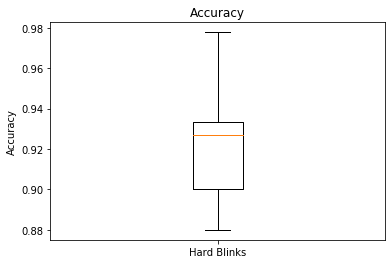

In [49]:
labels = ('Hard Blinks', 'random set 2')


plt.boxplot(x = acch)
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xticks([1],labels)
plt.savefig('hardblinks.png')
plt.show()



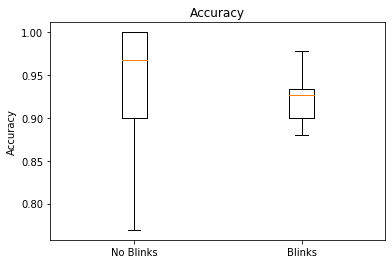

In [50]:
labels = ('No Blinks', 'Blinks')

plt.boxplot([accs, acch])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xticks([1,2],labels)
plt.savefig('combined.png')
plt.show()

# Question Bank

In [51]:
print(accs)
print(sum(accs)/(len(accs)))


[1.0, 1.0, 1.0, 1.0, 0.8717948717948718, 0.9090909090909091, 0.967741935483871, 0.9, 0.7692307692307693]
0.935317609511158


In [52]:
print(acch)
print(sum(acch)/(len(acch)))

[0.9, 0.88, 0.926829268292683, 0.9629629629629629, 0.9777777777777777, 0.896551724137931, 0.927536231884058, 0.9333333333333333, 0.9230769230769231]
0.9253409134961854
